<a href="https://colab.research.google.com/github/analystanand/Machine-Learning/blob/master/Card_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capital One Data Science Challenge

# Content


1. Introduction  
2. Project Requirements
2. Download and Extract data
3. Library Installations
4. Package Imports 
3. Load Transaction data into Dataframe
4. Summary of data
5. Histogram of monetary features
6. Data Wrangling - Duplicate Transactions
7. Predictive Modeling





#Introduction

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

#Project Requirement
1. IDE: Google Colab/Jupyter Notebook
2. Language: Python


# How to run code code
1. Open notebook in Jupyter Notebook or Google Collab(preferably)
2. Install mentioned requirements from below by running library installations cell. or `!pip install -r requirements.txt`



#Library Installations and Package Imports
Install all dependencies once and then comment for multiple runs to avoid

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 102kB 2.4MB/s 


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import jsonlines
import matplotlib
from sklearn.pipeline import Pipeline,make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Question 1:Download, Extract and Load Data

In [3]:
!git clone https://github.com/CapitalOneRecruiting/DS.git
!unzip DS/transactions.zip

Cloning into 'DS'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 3 (delta 0), pack-reused 1
Unpacking objects: 100% (4/4), done.
Archive:  DS/transactions.zip
  inflating: transactions.txt        


Read transactions.txt from file and load into pandas dataFrame

In [0]:
FILENAME= "./transactions.txt"
transactions = []
with jsonlines.open(FILENAME) as file:
    transactions = [record for record in file]
transactions_df = pd.DataFrame(transactions)

In [5]:
transactions_df.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [6]:
print("Number of transaction records:",transactions_df.shape[0])
print("No. of Customers:",transactions_df.customerId.unique().shape[0])
print("No. of Columns/Features:",transactions_df.shape[1]-1)

Number of transaction records: 786363
No. of Customers: 5000
No. of Columns/Features: 28


In [7]:
print("pandas data types")
transactions_df.dtypes

pandas data types


accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd             object
expirationDateKeyInMatch    

Data Types of features

Data types of features are not explicit with pandas data types. So by looking at a few rows, we can infer data types. It's important to identify data types of features as various models treat categorical and continuous features differently. Different data types will go through different preprocessing steps for feeding them into the model. Some features which don't contain any data will be dropped.
 
Categorical features need to be encoded and Numerical Features might be normalized for models to converge.
 
Datetime might be used to derive a numerical type. For example. Difference between transactionDate and dateOfLastAddressChange might be useful features in the prediction of fraud.

1. accountNumber
2. customerId
3. creditLimit
4. availableMoney
5. currentBalance
6. cardCVV
7. enteredCVV
8. cardLast4Digits


DateTime Data Type
1. transactionDateTime
2. currentExpDate
3. accountOpenDate
4. dateOfLastAddressChange

Categorical Data Type
1. merchantName
2. acqCountry
3. merchantCountryCode
4. posEntryMode
5. posConditionCode
6. merchantCategoryCode
7. transactionType
8. cardPresent
9. expirationDateKeyInMatch


Null Features
1. echoBuffer 
2. merchantCity 
3. merchantState 
4. merchantZip 
5. posOnPremises
6. recurringAuthInd

Target Variable
1. isFraud
 



There are few null columns/features(might be removed for privacy reasons) which are not useful for analysis and need to be dropped.

In [0]:
empty_columns = []
for i in transactions_df.columns.values:
  #check only single item in a column
  if len(set(transactions_df[i]))==1:
     empty_columns.append(i)
transactions_df = transactions_df.drop(empty_columns,axis=1)

Let's check if any data is missing, we might need to fill them with appropriate techniques.

In [9]:
print("Number of missing data(if any)",transactions_df.isnull().values.sum()) 

Number of missing data(if any) 0


Common Statistics  about numerical features

In [10]:
transactions_df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


In [0]:
transactions_df['transaction_id'] = transactions_df.index #for uniquely identifying transactions for using into groupBy operation

#Question 2: Plot
Histogram of monetary features

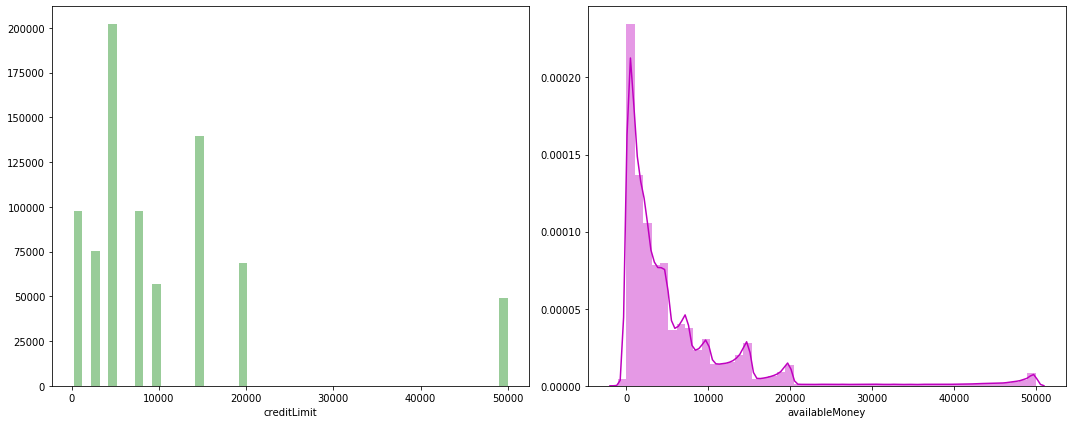

In [12]:
#reference:https://seaborn.pydata.org/examples/distplot_options.html
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.distplot(transactions_df['creditLimit'],kde=False, color="g", ax=axes[0])
sns.distplot(transactions_df['availableMoney'],kde=True,color="m", ax=axes[1])
plt.tight_layout()
plt.show()

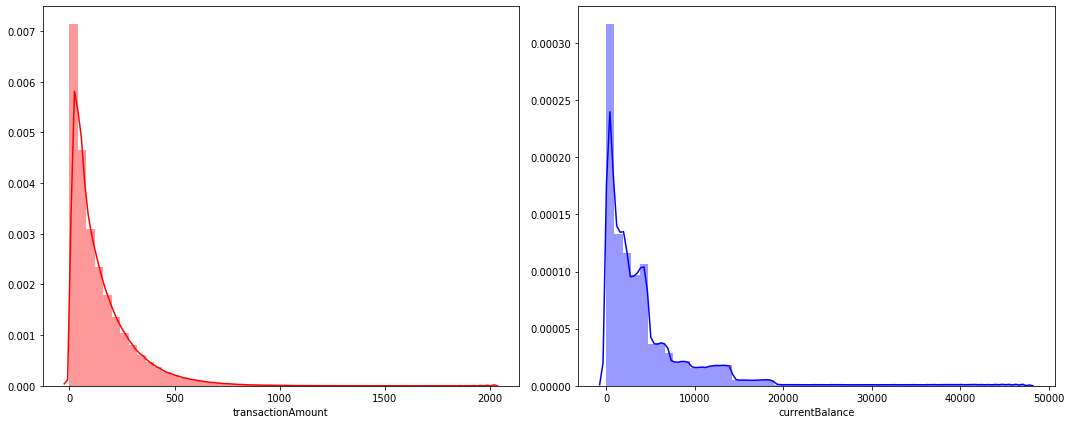

In [13]:
#reference:https://seaborn.pydata.org/examples/distplot_options.html
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.distplot(transactions_df['transactionAmount'],kde=True,norm_hist=True, color="r", ax=axes[0])
sns.distplot(transactions_df['currentBalance'],kde=True,norm_hist=True,color="b", ax=axes[1])
plt.tight_layout()
plt.show()

Approximately, Transactions Amount is in shape of positive skewed normal distribution

#Question 3: Data Wrangling - Duplicate Transactions

Combination of customerId, Transaction Amount and Merchant Name will help in identifying transactions uniquely and counting its repetition will help us in identifying reversed and multi-swipe. Multi-swipe  can be identified as transaction repeating more than once after filtering out regular transactions.

In [0]:
transaction_with_dup_flag = transactions_df[["customerId","transactionAmount","merchantName"]].duplicated()

In [0]:
transactions_df["isDuplicate"]=transaction_with_dup_flag

In [0]:
duplicate_transactions = transactions_df[transactions_df["isDuplicate"]==True]

In [0]:
result =  duplicate_transactions[["customerId","transactionAmount","merchantName","transactionDateTime"]].groupby(by=["customerId","transactionAmount","merchantName"]).count()

In [0]:
dup_analysis_df = result.reset_index()

In [0]:
dup_analysis_df = dup_analysis_df.rename(columns={"transactionDateTime": "occurence"})

In [0]:
dup_analysis_df['dup_category'] = np.where(dup_analysis_df['occurence']>1, 'multi-swipe', 'reversed')

In [21]:
analysis = dup_analysis_df.groupby(by=["dup_category"]).sum()
analysis["percentageCount"] = round((analysis["occurence"]/analysis["occurence"].sum())*100,2)
analysis["percentageAmount"] = round((analysis["transactionAmount"]/analysis["transactionAmount"].sum())*100,2)
analysis.head()

,transactionAmount,occurence,percentageCount,percentageAmount
dup_category,,,,
multi-swipe,272232.43,47451,63.14,6.9
reversed,3674589.58,27696,36.86,93.1


Although percentage of multi-swipe occurence is around 63% but account for 93% of total duplicate transactions

# Question 4: Model

Predicting a transaction is a fraud comes under classification problem in Machine Learning.

Evaluation Metric
As it is imbalanced dataset and fraudulent cases are rare, We will carefully choose our evaluation metric.

1. We want to increase recall for fraudulent transactions which might also mean lower precision but it is trade off to minimize loss due to frauds.
2. We will use ROC curve, precision-recall(preferably) and confusion matrix for peformance on training set. 


Steps

1. Derive features which can not be directly feed into models. 

2. Distribution of Fraud and Normal Transaction

3. Drop features not useful for prediction for baseline model.It might be incoporated if performance is not good enough. 

4. Split data into Training and Testing set while mainiting ratio of class. (startify=True).Testing set will be used only for final performance so as to avoid any data leakage.

5. Descriptive analysis of features among classes in Training Set for visualization of identifying important features.

6. Pipeline for handling preprocessing: Label Encoding and Feature Scaling

7. PCA for visualization in lower dimension.

8. Train model for handling Imbalanced data

9. Handling Imbalanced data via Class weight loss function

10. Handling Imbalanced data via Random Undersampling.

11. Handling Imbalanced data via Random Oversampling.

In [0]:
transactions_df["transactionDateTime"] = pd.to_datetime(transactions_df["transactionDateTime"])

#### Derive Features 
We can derive features from datetime  features which might be useful for training a model.

1. Difference in days between transaction date and  date of last address.
2. Difference in days between transaction date and  date of account open date.
3. Difference in days between transaction date and  date of current exp date.

In [0]:
transactions_df["dateOfLastAddressChange"] = pd.to_datetime(transactions_df["dateOfLastAddressChange"])
transactions_df['diff_address_transactions'] = transactions_df['transactionDateTime'] - transactions_df['dateOfLastAddressChange']
transactions_df['diff_address_transactions'] = transactions_df['diff_address_transactions']/np.timedelta64(1,'D')

In [0]:
transactions_df["accountOpenDate"] = pd.to_datetime(transactions_df["accountOpenDate"])
transactions_df['diff_accountopen_transactions'] = transactions_df['transactionDateTime'] - transactions_df['accountOpenDate']
transactions_df['diff_accountopen_transactions'] = transactions_df['diff_accountopen_transactions']/np.timedelta64(1,'D')

In [0]:
transactions_df["currentExpDate"] = pd.to_datetime(transactions_df["currentExpDate"],infer_datetime_format=True)
transactions_df['diff_currentExpDate_transactions'] =  transactions_df['currentExpDate'] - transactions_df['transactionDateTime'] 
transactions_df['diff_currentExpDate_transactions'] = transactions_df['diff_currentExpDate_transactions']/np.timedelta64(1,'D')


####Distribution of Fraud and Normal Transaction

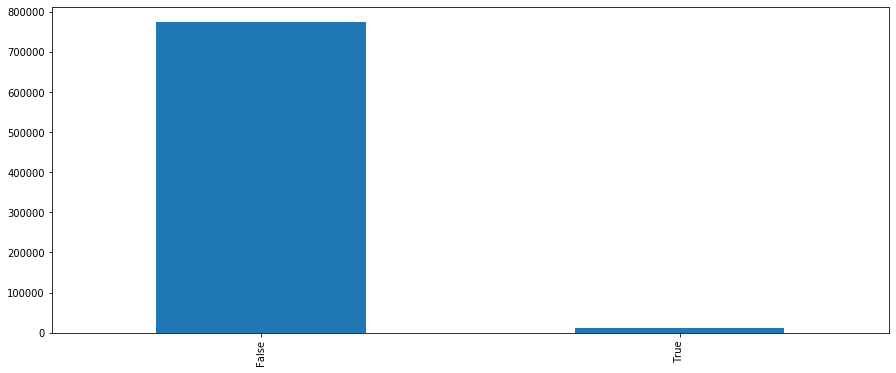

In [26]:
a4_dims = (15, 6)
fig, ax = plt.subplots(figsize=a4_dims)
class_dist=pd.value_counts(transactions_df["isFraud"], sort= True)
class_dist.plot(kind= 'bar')
plt.show()

In [27]:
def class_percentage(t_df):
  No_of_Normal_transacation = len(t_df[t_df["isFraud"]==True]) 
  No_of_Fraud_transacation =len(t_df[t_df["isFraud"]==False])
  percent_of_fraud_transaction =  No_of_Fraud_transacation/(No_of_Normal_transacation+No_of_Fraud_transacation)
  percent_of_normal_transaction = No_of_Normal_transacation/(No_of_Normal_transacation+No_of_Fraud_transacation)
  print("percent of Normal transactions: {0:.2%}".format(percent_of_fraud_transaction))
  print("percent of Fraud transactions: {0:.2%}".format(percent_of_normal_transaction))

class_percentage(transactions_df)

percent of Normal transactions: 98.42%
percent of Fraud transactions: 1.58%


As we can see that fraud transactions are just 1.58% of total transactions. This is highly imbalanced dataset so we have to carefully choose metric for performance evaluation as well as train a model which is not baised towards normal transaction.For example: randomly predicting all transaction as normal will provide high accuracy to the model but it's not useful for us. 


---
There are few techniques to handle imbalanced data.
1. Custom loss function to penalize model when it observe minority class
2. Random Undersampling the majority class
3. Random and SMOTE based Oversampling the minority class
4. Ensemble of classifier trained on minority class and different sets of majority class and use majority vote.

We will try only undersampling method although we will lose information but to train a model without an inherent bias towards majority class.

First of all lets seperate the data into training and test set before undersampling this is real scenarios we will be facing when it comes to deployment.

In [28]:
transactions_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_id,isDuplicate,diff_address_transactions,diff_accountopen_transactions,diff_currentExpDate_transactions
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,0,False,518.602454,518.602454,2482.397546
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,1,False,577.212431,577.212431,2668.787569
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,2,False,605.387951,605.387951,3187.612049
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,3,True,637.093634,637.093634,3155.906366
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False,4,False,231.878310,231.878310,4938.121690


####Drop features not useful for prediction
Dropping features need not to be fed into baseline model or we have already derived features from those: 

1. accountNumber,
2. customerId,
3. transactionDateTime,
4. currentExpDate,
5. accountOpenDate
6. dateOfLastAddressChange
7. cardCVV	
8. enteredCVV	
9. cardLast4Digits

In [0]:
transactions_df = transactions_df.drop(["accountNumber","customerId","transactionDateTime","currentExpDate","accountOpenDate","dateOfLastAddressChange","cardCVV","enteredCVV","cardLast4Digits",],axis=1)

####Split data into Training and Testing set 

In [0]:
X_data = transactions_df.drop('isFraud', axis=1) #for train-test split
y_label = transactions_df['isFraud']

In [31]:
le = LabelEncoder()
label_encoder = le.fit(y_label)
y_label = label_encoder.transform(y_label)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2,stratify=y_label)

print("Training Size:",X_train.shape,"Testing Size:",X_test.shape)

Training Size: (629090, 18) Testing Size: (157273, 18)


In [0]:
train_df = X_train.copy() #temporary copy for analysis of training set
train_df["isFraud"] = pd.Series(le.inverse_transform(y_train))

### Descriptive analysis of features

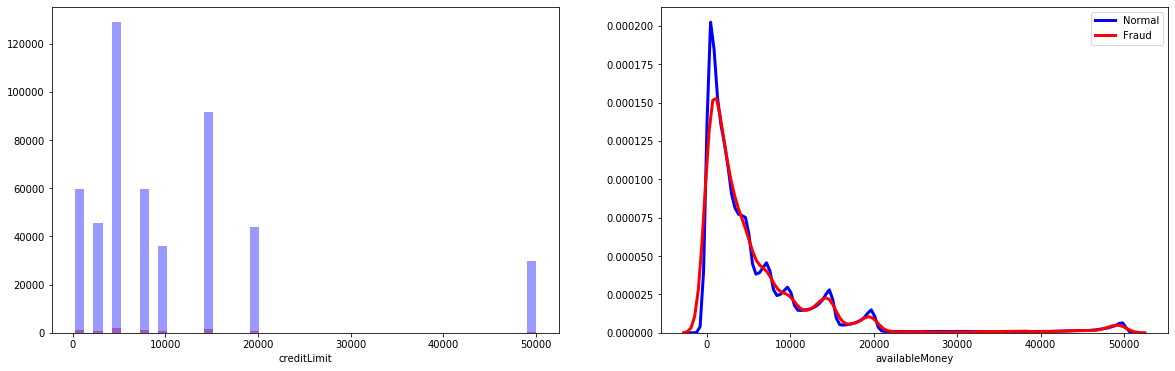

In [33]:
f, axes = plt.subplots(1,2, figsize=(20, 6), sharex=False)
sns.distplot(train_df[train_df['isFraud']==True]["creditLimit"],hist=True,kde=False,color="r",label='Fraud',ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==False]['creditLimit'],hist=True,kde=False,color="b",label='Normal',ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==False]['availableMoney'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[1])
sns.distplot(train_df[train_df['isFraud']==True]["availableMoney"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[1])
plt.legend()
plt.show()

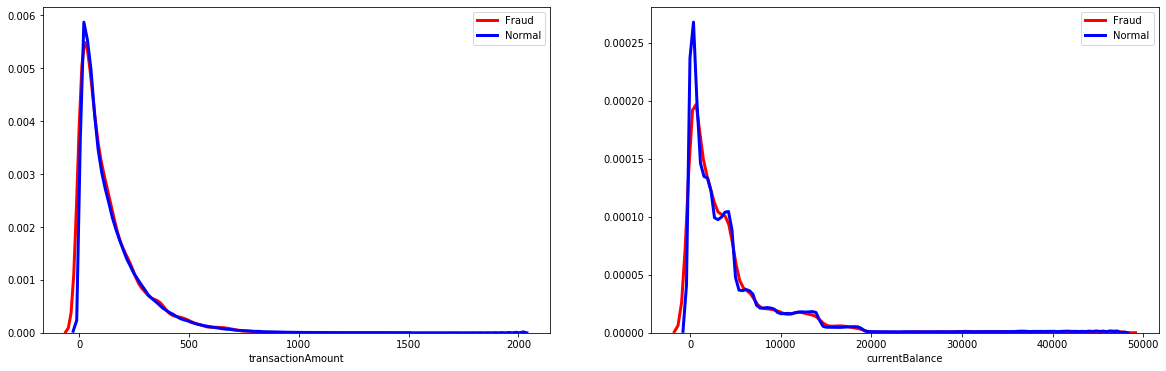

In [34]:
f, axes = plt.subplots(1,2, figsize=(20, 6), sharex=False)
sns.distplot(train_df[train_df['isFraud']==True]["transactionAmount"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==False]['transactionAmount'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==True]["currentBalance"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[1])
sns.distplot(train_df[train_df['isFraud']==False]['currentBalance'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[1])
plt.legend()
plt.show()

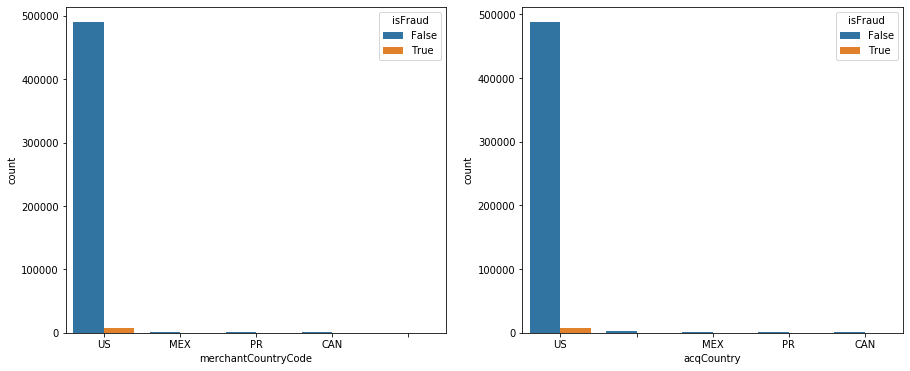

In [35]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('merchantCountryCode', data = train_df,hue="isFraud",ax=axes[0])
sns.countplot('acqCountry', data = train_df,hue="isFraud",ax=axes[1])
plt.show()

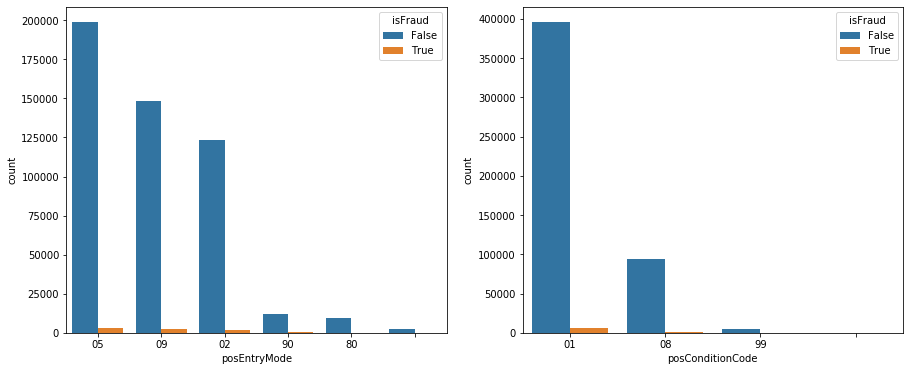

In [36]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('posEntryMode', data = train_df,hue="isFraud",ax=axes[0])
sns.countplot('posConditionCode', data = train_df,hue="isFraud",ax=axes[1])
plt.show()

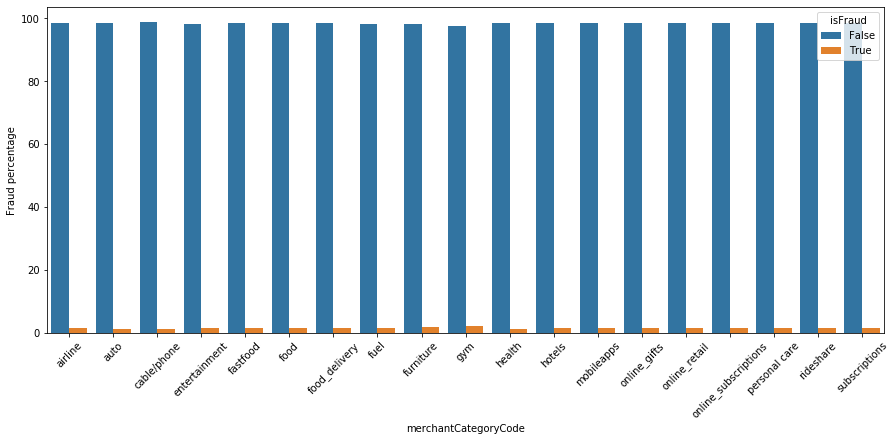

In [37]:
grp_by_merc_code = train_df.groupby(by=["merchantCategoryCode","isFraud"])["transaction_id"].count().reset_index()
grp_by_merc_code['Fraud percentage'] = grp_by_merc_code["transaction_id"]*100 / grp_by_merc_code.groupby("merchantCategoryCode")["transaction_id"].transform("sum")
a4_dims = (15, 6)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)
sns.barplot('merchantCategoryCode', 'Fraud percentage',hue = 'isFraud', data = grp_by_merc_code)
plt.show()

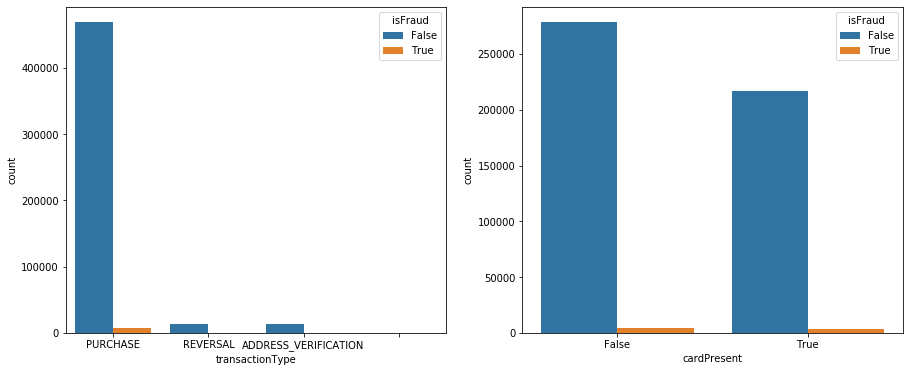

In [38]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('transactionType', data = train_df,hue="isFraud",ax=axes[0])
sns.countplot('cardPresent', data = train_df,hue="isFraud",ax=axes[1])
plt.show()

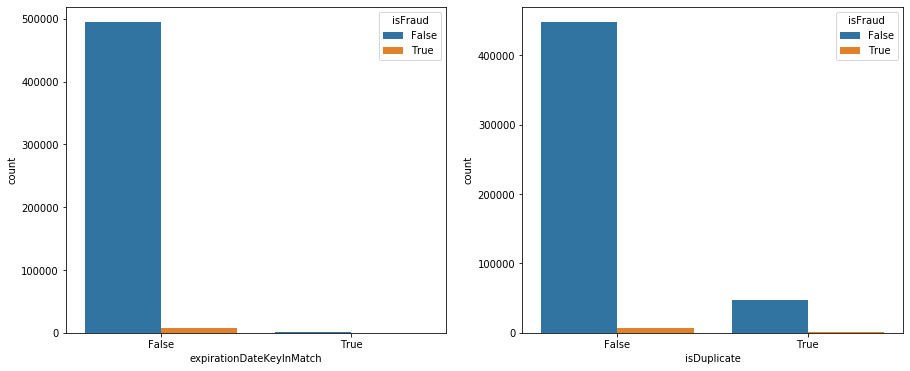

In [39]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('expirationDateKeyInMatch', data = train_df,hue="isFraud",ax=axes[0])
sns.countplot('isDuplicate', data = train_df,hue="isFraud",ax=axes[1])
plt.show()

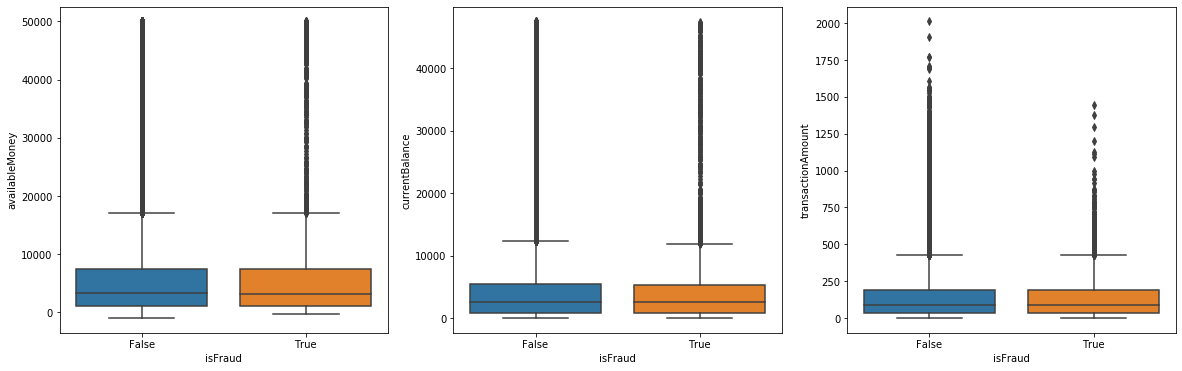

In [40]:
f, axes = plt.subplots(1,3, figsize=(20, 6), sharex=True)
ax = sns.boxplot(x="isFraud", y="availableMoney", data=train_df,ax =axes[0])
ax = sns.boxplot(x="isFraud", y="transactionAmount", data=train_df,ax =axes[2])
ax = sns.boxplot(x="isFraud", y="currentBalance", data=train_df,ax =axes[1])

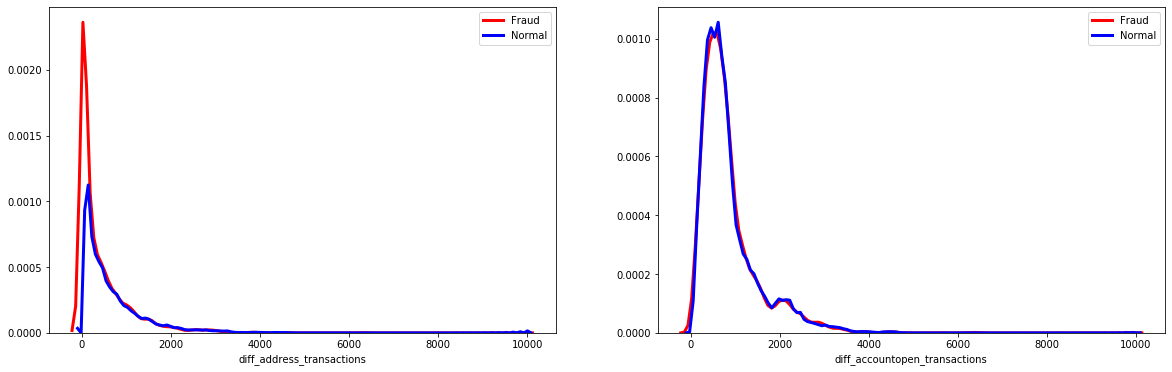

In [41]:
f, axes = plt.subplots(1,2, figsize=(20, 6), sharex=True)
sns.distplot(train_df[train_df['isFraud']==True]["diff_address_transactions"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==False]['diff_address_transactions'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==True]["diff_accountopen_transactions"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[1])
sns.distplot(train_df[train_df['isFraud']==False]['diff_accountopen_transactions'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[1])
plt.legend()
plt.show()

In [0]:
X_train_new = X_train.drop(["transaction_id"],axis=1) #drop columun transaction used for groupby on merchantCategoryCode
X_test_new = X_test.drop(["transaction_id"],axis=1)

###Pipeline for handling preprocessing
Label Encoding and Scaling of categorical and continuous features respectively.
different encoding might be utilized for improving performance of model.

In [0]:
numerical_features = X_train_new.select_dtypes(include=['float64']).columns
categorical_features = X_train_new.select_dtypes(include=['object','bool']).columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('woe', ce.OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features),('num', numeric_transformer, numerical_features)])

In [0]:
preprocessor.fit(X_train_new)
X_trans =  preprocessor.transform(X_train_new)
X_test_trans = preprocessor.transform(X_test_new)

###PCA Visualization 

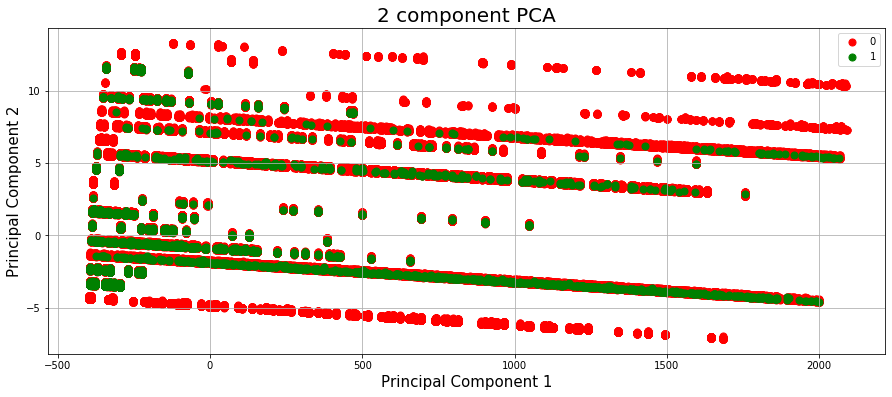

In [45]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_trans)
finalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf["target"]=y_train
fig = plt.figure(figsize = (15,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Observation of PCA of provides insights that linear classifier such as logistic regression(baseline) might not perform well and also choice of encoder also put inherent order for multiple categories.

###Approach 1:Handling Imbalanced Data via Custom Loss Function

              precision    recall  f1-score   support

           0       0.99      0.66      0.80    154790
           1       0.03      0.64      0.06      2483

    accuracy                           0.66    157273
   macro avg       0.51      0.65      0.43    157273
weighted avg       0.98      0.66      0.78    157273



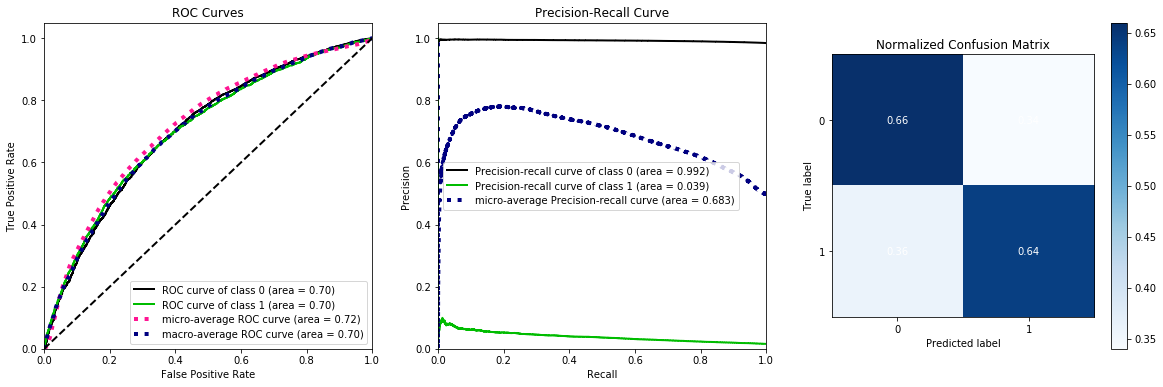

In [46]:
 clf = LogisticRegression(max_iter=800 ,class_weight="balanced")
 best_clf = clf.fit(X_trans, y_train)
 y_score = clf.predict_proba(X_test_trans)
 y_pred = clf.predict(X_test_trans)
 print(classification_report(y_test, y_pred))
 f, axes = plt.subplots(1,3, figsize=(20, 6), sharex=False)
 skplt.metrics.plot_roc(y_test, y_score,ax=axes[0])
 skplt.metrics.plot_precision_recall(y_test, y_score,ax=axes[1])
 skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,ax=axes[2])
 plt.show()

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   28.8s finished


best parameters {'class_weight': {1: 9}}
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    154790
           1       0.09      0.10      0.10      2483

    accuracy                           0.97    157273
   macro avg       0.54      0.54      0.54    157273
weighted avg       0.97      0.97      0.97    157273



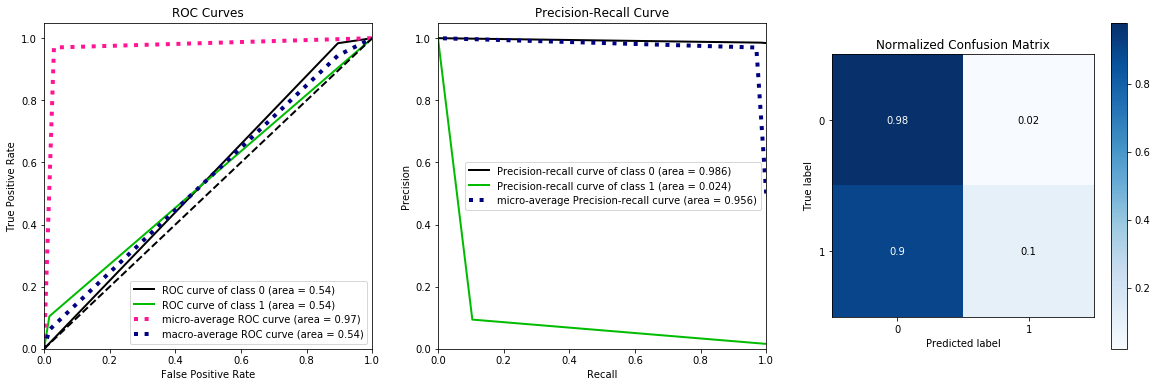

In [47]:
 param_grid = {'class_weight':[{1: w} for w in [3,6,9]]}
 clf = GridSearchCV( DecisionTreeClassifier(criterion="entropy"), scoring="recall_micro",param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1)
 best_clf = clf.fit(X_trans, y_train)
 print("best parameters",clf.best_params_)
 y_score = clf.predict_proba(X_test_trans)
 y_pred = clf.predict(X_test_trans)
 print(classification_report(y_test, y_pred))
 f, axes = plt.subplots(1,3, figsize=(20, 6), sharex=False)
 skplt.metrics.plot_roc(y_test, y_score,ax=axes[0])
 skplt.metrics.plot_precision_recall(y_test, y_score,ax=axes[1])
 skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,ax=axes[2])
 plt.show()

###Approach 2:Handling imbalanced data via undersampling


In [48]:
rus = RandomUnderSampler(random_state=5)
rus.fit(X_trans, y_train)
X_resampled, y_resampled = rus.fit_resample(X_trans, y_train)
print("Size of resampled data",X_resampled.shape[0])

Size of resampled data 19868


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.75      0.85    154790
           1       0.04      0.66      0.08      2483

    accuracy                           0.75    157273
   macro avg       0.52      0.70      0.46    157273
weighted avg       0.98      0.75      0.84    157273



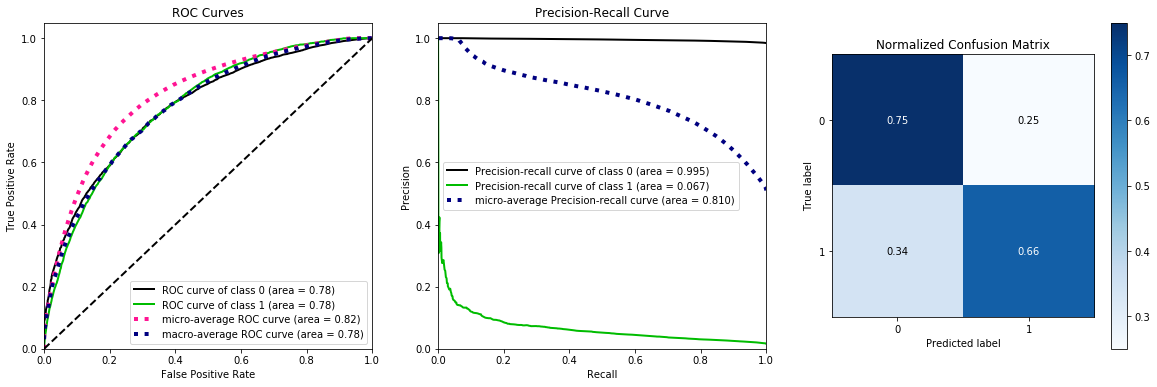

In [49]:
 clf = RandomForestClassifier(n_estimators=500, class_weight={1:6})
 best_clf = clf.fit(X_resampled, y_resampled)
 y_score = clf.predict_proba(X_test_trans)
 y_pred = clf.predict(X_test_trans)
 print(classification_report(y_test, y_pred))
 f, axes = plt.subplots(1,3, figsize=(20, 6), sharex=False)
 skplt.metrics.plot_roc(y_test, y_score,ax=axes[0])
 skplt.metrics.plot_precision_recall(y_test, y_score,ax=axes[1])
 skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,ax=axes[2])
 plt.show()

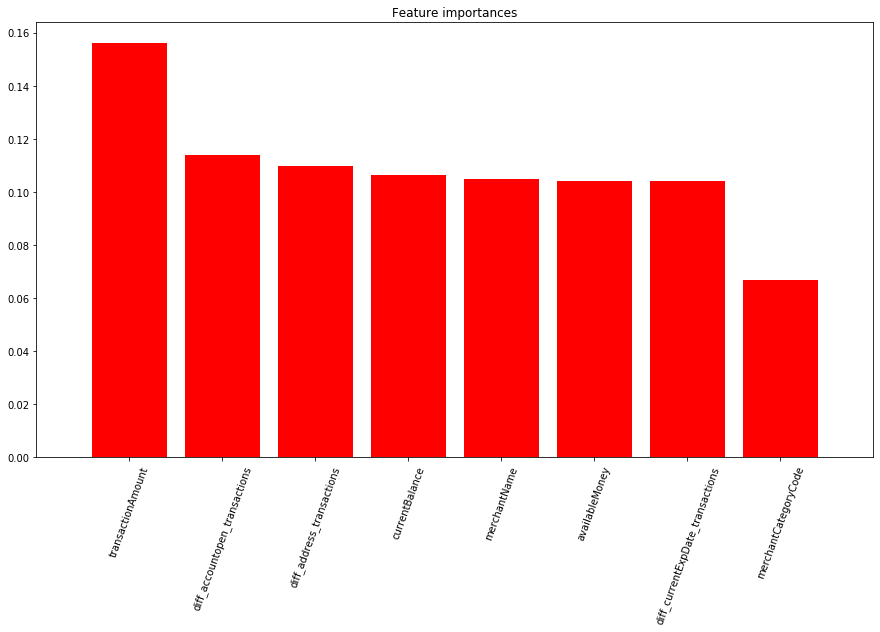

In [50]:
col_names = list(categorical_features.values)+list(numerical_features.values) #for feature importance
importances = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:8]
re_arranged_features = [ col_names[i] for i in indices][:8]
# Plot the feature importances of the forest
plt.figure(figsize=(15,8))
plt.title("Feature importances")
plt.bar(range(8), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(8),labels=re_arranged_features,rotation=70)
plt.xlim([-1, 8])

plt.show()

###Approach 3:Handling imbalanced data via random oversampling


In [51]:
ros = RandomOverSampler(random_state=5)
ros.fit(X_trans, y_train)
X_resampled, y_resampled = ros.fit_resample(X_trans, y_train)
print("Size of resampled data",X_resampled.shape[0])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Size of resampled data 1238312


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    154790
           1       0.74      0.03      0.06      2483

    accuracy                           0.98    157273
   macro avg       0.86      0.52      0.53    157273
weighted avg       0.98      0.98      0.98    157273



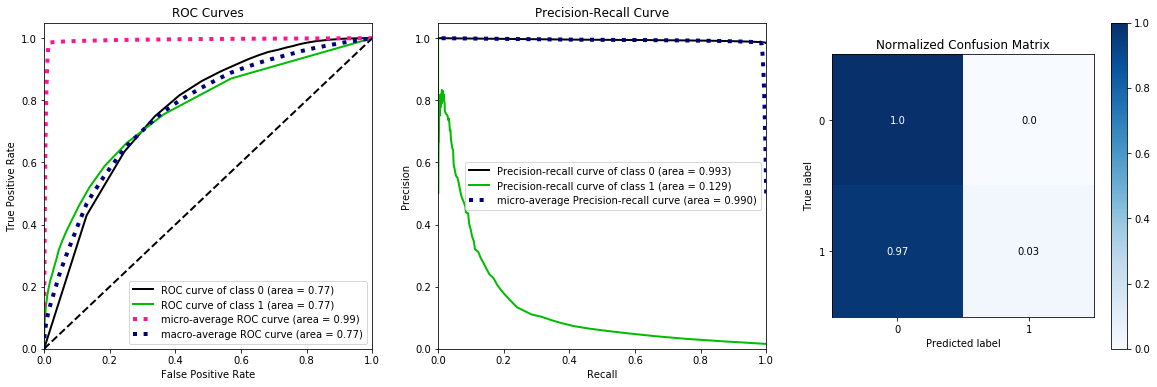

In [52]:
 clf = RandomForestClassifier()
 best_clf = clf.fit(X_resampled, y_resampled)
 y_score = clf.predict_proba(X_test_trans)
 y_pred = clf.predict(X_test_trans)
 print(classification_report(y_test, y_pred))
 f, axes = plt.subplots(1,3, figsize=(20, 6), sharex=False)
 skplt.metrics.plot_roc(y_test, y_score,ax=axes[0])
 skplt.metrics.plot_precision_recall(y_test, y_score,ax=axes[1])
 skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,ax=axes[2])
 plt.show()

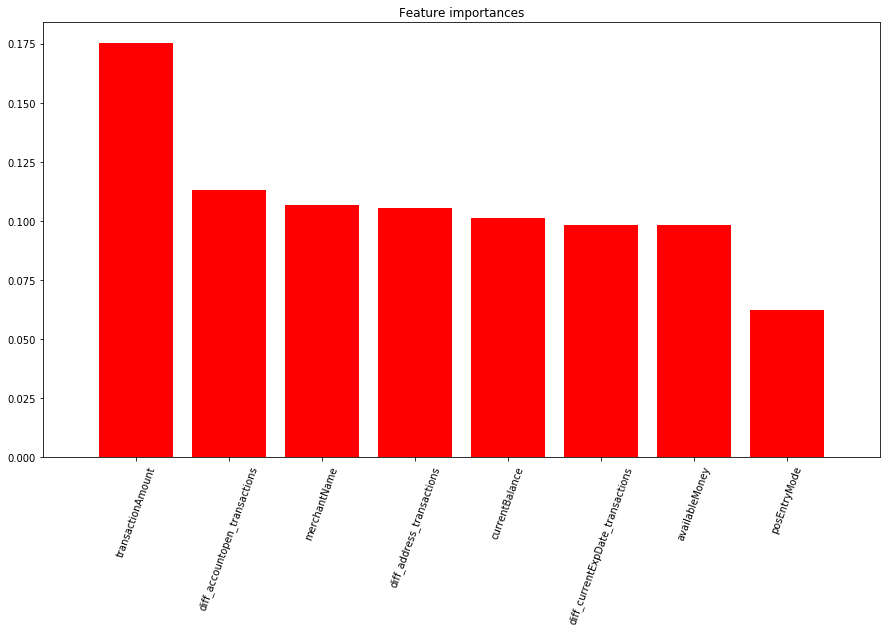

In [53]:
col_names = list(categorical_features.values)+list(numerical_features.values) #for feature importance
importances = clf.feature_importances_
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:8]
re_arranged_features = [ col_names[i] for i in indices][:8]
# Plot the feature importances of the forest
plt.figure(figsize=(15,8))
plt.title("Feature importances")
plt.bar(range(8), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(8),labels=re_arranged_features,rotation=70)
plt.xlim([-1, 8])

plt.show()

#Conclusion
Its quite challenging to handle imbalanced dataset.Let's Look at the result fraud class precision and recall.






References:
1.  [An Easier Way to Encode Categorical Features](https://towardsdatascience.com/an-easier-way-to-encode-categorical-features-d840ff6b3900)
2. [Seaborn documentation](https://seaborn.pydata.org/tutorial.html)
3. [PCA visualization](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)
4. [Random Forest Feature Importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)